# Part - 1: Exploratory data analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import cv2
from PIL import Image
os.getcwd()

'/home/icog/yonathan/chest-xray-imaging'

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
# add image filepath to the dataframe
all_xray_df = pd.read_csv('input/chest_xrays/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('input', 'chest_xrays', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
62157,00015377_000.png,Infiltration|Nodule,0,15377,51,M,PA,2500,2048,0.168,0.168,NaN,input/chest_xrays/images_007/images/00015377_0...
42502,00010936_020.png,No Finding,20,10936,39,F,PA,2500,2048,0.168,0.168,NaN,input/chest_xrays/images_005/images/00010936_0...
22943,00006055_002.png,Consolidation,2,6055,38,F,PA,2048,2500,0.168,0.168,NaN,input/chest_xrays/images_003/images/00006055_0...


In [ ]:
# Print the summary of the dataframe 
all_xray_df.info() 

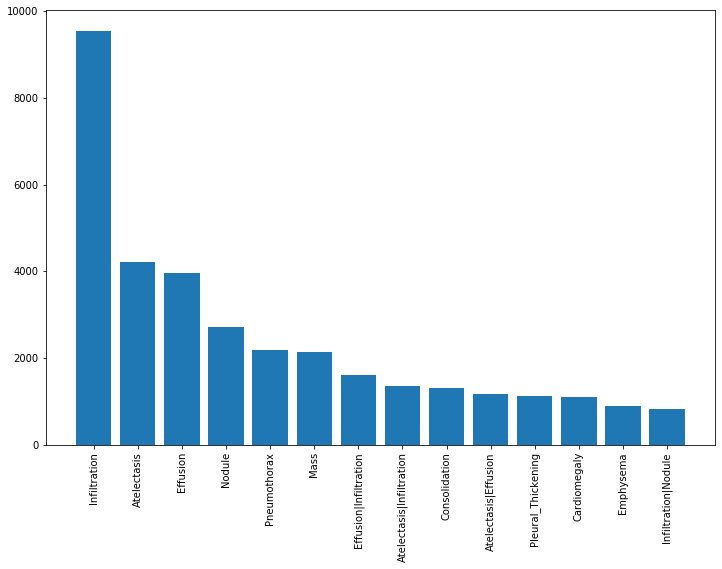

In [4]:
# visualizing label counts
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Part - 2: Prepare the data

In [5]:
# change the labels to one hot encoded values
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
# all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
63486,00015658_018.png,Atelectasis,18,15658,53,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
83767,00020579_000.png,Infiltration,0,20579,66,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0
30359,00007916_007.png,Emphysema,7,7916,63,M,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# use only some of the columns
save_columns = ['Image Index', 'Finding Labels', 'path', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
                'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
updated_xray_df = all_xray_df.loc[:, save_columns]
updated_xray_df.sample(3)

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
57280,00014207_001.png,,input/chest_xrays/images_007/images/00014207_0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99588,00026369_002.png,,input/chest_xrays/images_011/images/00026369_0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111602,00030561_006.png,Atelectasis|Hernia|Infiltration|Mass|Nodule|Pn...,input/chest_xrays/images_012/images/00030561_0...,1,0,0,0,0,0,0,1,1,1,1,0,0,1


In [ ]:
# under-sampling the datasets

# under sampled classes
no_finding_df = updated_xray_df[updated_xray_df.iloc[:, -3:] == 0].sample(1500) 
Infiltration_df = updated_xray_df[updated_xray_df['Infiltration'] == 1].sample(1500)
Atelectasis_df = updated_xray_df[updated_xray_df['Atelectasis'] == 1].sample(1500)

Effusion_df = updated_xray_df[updated_xray_df['Effusion'] == 1].sample(1500)
Nodule_df = updated_xray_df[updated_xray_df['Nodule'] == 1].sample(1500)
Pneumothorax_df = updated_xray_df[updated_xray_df['Pneumothorax'] == 1].sample(1500)
Mass_df = updated_xray_df[updated_xray_df['Mass'] == 1].sample(1500)

# unsampled classes
Consolidation_df = updated_xray_df[updated_xray_df['Consolidation'] == 1]
Pleural_Thickening_df = updated_xray_df[updated_xray_df['Pleural_Thickening'] == 1]
Cardiomegaly_df = updated_xray_df[updated_xray_df['Cardiomegaly'] == 1]
Emphysema_df = updated_xray_df[updated_xray_df['Emphysema'] == 1]

Fibrosis_df = updated_xray_df[updated_xray_df['Fibrosis'] == 1]
Edema_df = updated_xray_df[updated_xray_df['Edema'] == 1]
Pneumonia_df = updated_xray_df[updated_xray_df['Pneumonia'] == 1]
Hernia_df = updated_xray_df[updated_xray_df['Hernia'] == 1]

# DataFrames Concatenation
sampled_classes_df = pd.concat([no_finding_df, Infiltration_df, Atelectasis_df, 
                                Effusion_df, Nodule_df, Pneumothorax_df, Mass_df], 
                                axis=0)
unsampled_classes_df = pd.concat([Consolidation_df, Pleural_Thickening_df, Cardiomegaly_df, Emphysema_df,
                                  Fibrosis_df, Edema_df, Pneumonia_df, Hernia_df], 
                                  axis=0)
sampled_xray_df = pd.concat([sampled_classes_df, unsampled_classes_df], axis=0)

In [7]:
# # generate train_val dataframe and save it to csv
# train_val_image_indexes = []
# with open('../input/data/train_val_list.txt') as file:
#     for line in file:
#         line = line.strip()
#         train_val_image_indexes.append(line)
        
# train_val_list_df = sampled_xray_df[sampled_xray_df['Image Index'].map(lambda x: True if x in train_val_image_indexes else False)]
# # train_val_list_df = train_val_list_df.drop(columns=['Finding Labels', 'path'])
# train_val_list_df.to_csv(os.path.join('../working', 'train_val_list.csv'), index=False)

In [8]:
# # generate train_val dataframe and save it to csv
# test_image_indexes = []
# with open('../input/data/test_list.txt') as file:
#     for line in file:
#         line = line.strip()
#         test_image_indexes.append(line)
        
# test_list_df = sampled_xray_df[sampled_xray_df['Image Index'].map(lambda x: True if x in test_image_indexes else False)]
# # test_list_df = test_list_df.drop(columns=['Finding Labels', 'path'])
# test_list_df.to_csv(os.path.join('../working', 'test_list.csv'), index=False)

In [9]:
# print('train_val:', train_val_list_df.shape[0], '\ttest:', test_list_df.shape[0])

In [10]:
# move training image to image/train_val directory
# import shutil
# dst_path = '../input/data/images/train_val'
# for image_index in train_val_list_df['Image Index']:
#     try:
#         shutil.move(image_index, dest_path)
#     except:
#         print("image file conflict occured.")

In [26]:
# def convert_text_to_list(text_list_path):
#     data = pd.read_csv(text_list_path, sep=" ", header=None)
#     data_list = data.values.tolist()
#     return data_list

In [49]:
# split the dataset into 70% training, 10% validation and 20% test
# image_indexes = np.array(sampled_xray_df['Image Index'])

# np.random.shuffle(image_indexes)
# train_indexes = image_indexes[:train_len]
# val_indexes = image_indexes[train_len: train_len + val_len]
# test_indexes = image_indexes[train_len + val_len: ]

# train_val_list_path = 'input/chest_xrays/train_val_list.txt'
# test_list_path = 'input/chest_xrays/test_list.txt'

# train_val_indexes = convert_text_to_list(train_val_list_path)
# train_end = int(len(train_val_indexes) * 0.85)
# train_indexes = train_val_indexes[:train_end]
# val_indexes = train_val_indexes[train_end:]
# test_indexes = convert_text_to_list(test_list_path)

# train_indexes = np.array(train_indexes).reshape(-1).tolist()
# val_indexes = np.array(val_indexes).reshape(-1).tolist()
# test_indexes = np.array(test_indexes).reshape(-1).tolist()

# train_path = "input/chest_xrays/train.csv"
# val_path = "input/chest_xrays/val.csv"
# test_path = "input/chest_xrays/test.csv"

# if not os.path.exists(train_path):
#     train_df = updated_xray_df[sampled_xray_df['Image Index'].map(lambda x: True if x in train_indexes else False)]
#     train_df.to_csv(train_path, index=False)
# if not os.path.exists(val_path):
#     val_df = updated_xray_df[sampled_xray_df['Image Index'].map(lambda x: True if x in val_indexes else False)]
#     val_df.to_csv(val_path, index=False)
# if not os.path.exists(test_path):
#     test_df = updated_xray_df[sampled_xray_df['Image Index'].map(lambda x: True if x in test_indexes else False)]
#     test_df.to_csv(test_path, index=False)

In [11]:
# split the dataset into 90% training, 5% validation and 5% test
def train_validation_test_split(df, train_percent=.9, validation_percent=.05, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validation_end = int(validation_percent * m) + train_end
    train_df = df.iloc[perm[:train_end]]
    val_df = df.iloc[perm[train_end:validation_end]]
    test_df = df.iloc[perm[validation_end:]]
    return train_df, val_df, test_df

(train_df, val_df, test_df) = train_validation_test_split(sampled_xray_df)

train_path = "input/chest_xrays/train.csv"
val_path = "input/chest_xrays/val.csv"
test_path = "input/chest_xrays/test.csv"

if not (os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path)):
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)

In [64]:
print(train_df.head(5)['Image Index'])
print("====================")
print(val_df.head(5)['Image Index'])
print("======================")
print(test_df.head(5)['Image Index'])

0    00000001_000.png
1    00000001_001.png
2    00000001_002.png
3    00000002_000.png
4    00000004_000.png
Name: Image Index, dtype: object
0    00023498_007.png
1    00023498_008.png
2    00023498_009.png
3    00023498_010.png
4    00023499_000.png
Name: Image Index, dtype: object
0    00000003_000.png
1    00000003_001.png
2    00000003_002.png
3    00000003_003.png
4    00000003_004.png
Name: Image Index, dtype: object


In [51]:
train_len = len(train_df)
val_len = len(val_df)
test_len = len(test_df)

print(train_len/(train_len + val_len + test_len))
print(val_len/(train_len + val_len + test_len))
print(test_len/(train_len + val_len + test_len))

0.6559489832322511
0.11575990010702819
0.22829111666072066


# Part - 3: Build the model

In [52]:
# from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import Adam

In [53]:
# fine-tune densenet model
def create_model(input_shape=(224, 224, 3), num_classes=14, show_summary=False):
    img_input = Input(shape=input_shape)
    densenet_model = DenseNet121(include_top=False,
                                 weights="imagenet",
                                 input_tensor=img_input,
                                 input_shape=input_shape,
                                 pooling="avg"
                                )
    x = densenet_model.output
    predictions = Dense(num_classes, activation="sigmoid", name="predictions")(x)
    model = Model(inputs=img_input, outputs=predictions)
    if show_summary:
        model.summary()

    return model

# Part - 4: Train the model

In [54]:
# check output_dir, create it if not exists
output_dir = "./output"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
    os.makedirs(os.path.join(output_dir, "models"))
    os.makedirs(os.path.join(output_dir, "model_architecture"))
    os.makedirs(os.path.join(output_dir, "model_weights"))
    os.makedirs(os.path.join(output_dir, "logs"))

In [55]:
# training configurations
train_path = "input/chest_xrays/train.csv"
val_path = "input/chest_xrays/val.csv"
test_path = "input/chest_xrays/test.csv"

class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis',
               'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
target_size=(224,224,3)
batch_size=32
epochs=100
initial_learning_rate = 0.001

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

train_steps = np.ceil(len(train_df)/batch_size)
validation_steps = np.ceil(len(val_df)/batch_size)
test_steps = np.ceil(len(test_df)/batch_size)

output_dir = "./output"
model_path = os.path.join(output_dir, "models/xray_imaging_model.h5")
model_architecture_path = os.path.join(output_dir, "model_architecure/xray_imaging_architecture.json")
model_weight_path = os.path.join(output_dir, "model_weights/xray_imaging_weights.h5")
log_dir = os.path.join(output_dir, "logs")

In [56]:
# define custom datagenerator
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, dataset_csv_file, class_names, batch_size=32, target_size=(224,224,3), shuffle=True):
        'Initialization'
        self.dataset_df = pd.read_csv(dataset_csv_file)
        self.indexes = np.array(self.dataset_df['Image Index'])
        self.image_paths = self.dataset_df['path']
        self.labels = self.dataset_df[class_names]
        self.batch_size = batch_size
        self.steps = np.ceil(len(self.dataset_df)/self.batch_size)
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_x = np.asarray([self.load_image(image_path) for image_path in batch_image_paths])
        batch_x = self.normalize_batch_images(batch_x)
        batch_y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        return batch_x, batch_y


    def load_image(self, image_path):
        image_path = os.path.join(os.getcwd(), image_path)
        image = Image.open(image_path)
        image_array = np.asarray(image.convert("RGB"))
        image_array = image_array / 255.
        image_array = np.resize(image_array, self.target_size)
        return image_array

    def normalize_batch_images(self, batch_x):
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        batch_x = (batch_x - imagenet_mean) / imagenet_std
        return batch_x
    
    def get_y_true(self):
        if self.shuffle:
            raise ValueError("shuffle value cannot be true when accessing y_true") 
#         return self.labels[:self.steps*self.batch_size, :]
        return np.array(self.labels)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [57]:
# create data generator
train_datagen = DataGenerator(dataset_csv_file = train_path,
                              class_names = class_names,
                              batch_size=batch_size,
                              target_size=target_size,
                              shuffle=True)

validation_datagen = DataGenerator(dataset_csv_file = val_path,
                                  class_names = class_names,
                                  batch_size=batch_size,
                                  target_size=target_size,
                                  shuffle=True)

In [58]:
# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping

checkpoint = ModelCheckpoint(model_weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.1, 
                             patience=1,
                             verbose=1, 
                             mode="min", 
                             min_lr=1e-8)

tensorboard = TensorBoard(log_dir=log_dir)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, reduceLR, tensorboard, earlystop]


In [60]:
# train the model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import multi_gpu_model

# resume training if exists
if os.path.exists(model_weight_path):
    # loading model architecture and weights
    
    print(" * loading trained model ....")
    # Model reconstruction from JSON file
    with open(model_architecture_path, 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the model
    model.load_weights(model_weight_path)
else:
    print("create new model")
    model = create_model()
    model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy",  metrics=["accuracy"])

# check multiple gpu availability
gpus = len(tf.config.experimental.list_physical_devices("GPU"))
if gpus >= 2:
    print(f"** multi_gpu_model is used! gpus={gpus} **")
    model = multi_gpu_model(model, gpus)
else:
    print("there is no gpu in this device")
model.fit_generator(train_datagen, 
                    steps_per_epoch=train_steps,
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_data=validation_datagen, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    max_queue_size=10, 
                    workers=1, 
                    use_multiprocessing=False, 
                    shuffle=True, 
                    initial_epoch=0)


create new model
there is no gpu in this device
Epoch 1/100
2298/2299 [============================>.] - ETA: 1s - loss: 0.1674 - accuracy: 0.9557
Epoch 00001: val_loss improved from inf to 0.16992, saving model to ./output/model_weights/xray_imaging_weights.h5
2299/2299 [==============================] - 2871s 1s/step - loss: 0.1674 - accuracy: 0.9557 - val_loss: 0.1699 - val_accuracy: 0.9519
Epoch 2/100
2298/2299 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9560
Epoch 00002: val_loss did not improve from 0.16992

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2299/2299 [==============================] - 2880s 1s/step - loss: 0.1656 - accuracy: 0.9560 - val_loss: 0.3507 - val_accuracy: 0.9368
Epoch 3/100
2298/2299 [============================>.] - ETA: 1s - loss: 0.1623 - accuracy: 0.9561
Epoch 00003: val_loss did not improve from 0.16992

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
2299

In [61]:
# save model architecture
# serialize model to json
model = create_model()
model_json = model.to_json()
with open(model_architecture_path, "w") as json_file:
    json_file.write(model_json)

# Part - 5: Analyze the model’s results 

In [62]:
# testing configurations
test_path = "input/chest_xrays/test.csv"
target_size = (224, 224, 3)

In [63]:
from tensorflow.keras.models import model_from_json
   
# loading model architecture and weights
def get_model(model_architecture_path, model_weight_path):
    global model
    
    # Model reconstruction from JSON file
    with open(model_architecture_path, 'r') as f:
        model = model_from_json(f.read())
        
#     # compile the model
#     model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy",  metrics=["accuracy"])
        
    # Load weights into the model
    model.load_weights(model_weight_path)
    print(" * model loaded!")

In [92]:
# auroc test
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print(" * loading trained model ....")
get_model(model_architecture_path, model_weight_path)

test_datagen = DataGenerator(dataset_csv_file = test_path,
                             class_names = class_names,
                             batch_size=batch_size,
                             target_size=target_size,
                             shuffle=False)

print("** making prediction **")
y_pred = model.predict_generator(test_datagen, verbose=1)
y = np.array(test_datagen.labels)

test_log_path = os.path.join(output_dir, "test.log")
print(f"** write log to {test_log_path} **")
aurocs = []
accuracy = []
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            auroc_score = roc_auc_score(y[:, i], y_pred[:, i])
            aurocs.append(auroc_score)
            accuracy.append(accuracy_score(np.round(y[:, i]).astype(int), np.round(y_pred[:, i]).astype(int)))
        except ValueError:
            auroc_score = 0
        f.write(f"{class_names[i]}: {auroc_score}\n")
    mean_auroc = np.mean(aurocs)
    mean_accuracy = np.mean(accuracy)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")
    print(f"mean accuracy: {mean_accuracy}")

** write log to ./output/test.log **
mean auroc: 0.5229778869648208
mean accuracy: 0.924078539057442


In [83]:
# test accuracy
from sklearn.metrics import accuracy_score

accuracy = []
for i in range(len(class_names)):
    accuracy.append(accuracy_score(np.round(y[:, i]).astype(int), np.round(y_pred[:, i]).astype(int)))
mean_accuracy = np.mean(accuracy)
print(f"mean accuracy: {mean_accuracy}")

mean accuracy: 0.924078539057442


In [125]:
# load the image
from PIL import Image

def load_image(image, target_size=(224, 224, 3)):
    image_array = np.asarray(image.convert("RGB"))
    image_array = image_array / 255.
    image_array = np.resize(image_array, target_size)
    image_tensor = np.expand_dims(image_array, axis=0)
    return image_tensor

In [66]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

def preprocess_image(image, target_size):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image_array = img_to_array(image)/225.
    image_tensor = np.expand_dims(image, axis=0)
    return image_tensor

In [67]:
def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [68]:
# heatmap
from tensorflow.keras.backend import function
import cv2

def heatmap(model, image, target_size):
    # build tensorflow computational graph
    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = model.layers[-3]
    get_output = function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output(image)
    conv_outputs = conv_outputs[0, :, :, :]
    
    # compute class activation map(CAM)
    print("predictions", predictions)
    image_class = np.argmax(predictions)
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for index, weight in enumerate(class_weights[:, image_class]):
      cam += weight * conv_outputs[:, :, index]

    # merge the original image and the class activation map
    cam /= np.max(cam)
    cam = cv2.resize(cam, target_size[:-1])
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.2)] = 0
    heatmap = heatmap * 0.5 + image
    
    return heatmap

In [70]:
import cv2
from PIL import Image
def predict(model, image, target_size=(224, 224), show_heatmap=False):
    processed_image = load_image(image)
    prediction = model.predict(processed_image).tolist()
    
    preprocessed_image = preprocess_image(image, target_size)
    prediction = model.predict(preprocessed_image).tolist()
    if show_heatmap:
        original_image = np.asarray(image.convert("RGB"))
        transformed_image = transform_image(image)
        predicted_class_index = np.argmax(prediction)
        heatmap_img = heatmap(model, original_image, transformed_image, predicted_class_index)
        return (prediction, heatmap_img)
    else:
        return prediction

In [71]:
def predicted_classes(prediction, class_names):
    index = 0
    predicted_classes = []
    for pred in prediction[0]:
        if pred >= 0.5:
            predicted_classes.append(class_names[index])
        index = index + 1
    return predicted_classes

In [106]:
from tensorflow.keras.preprocessing import image
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [73]:
print(" * Trained model loading.... ")
get_model(model_architecture_path, model_weight_path)

 * Trained model loading.... 
 * model loaded!


In [116]:
test_df.head(10)

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000003_000.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,00000003_001.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,00000003_002.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,00000003_003.png,Hernia|Infiltration,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,00000003_004.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00000003_005.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,00000003_006.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,00000003_007.png,Hernia,input/chest_xrays/images_001/images/00000003_0...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,00000013_000.png,NaN,input/chest_xrays/images_001/images/00000013_0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,00000013_001.png,Emphysema|Pneumothorax,input/chest_xrays/images_001/images/00000013_0...,0,0,0,0,0,1,0,0,0,0,0,0,0,1


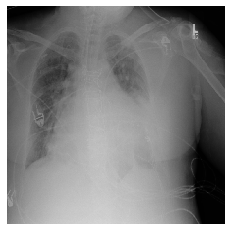

[[0.11076105 0.01397517 0.02233016 0.01835963 0.08319673 0.016397
  0.01701817 0.00028294 0.20944288 0.07172102 0.0198822  0.0247137
  0.00628091 0.01820374]]


In [123]:
image_path = test_df.head(100)['path'][90]
image_tensor = load_image(image_path, True)
prediction = model.predict(image_tensor)
print(prediction)

In [129]:
image_path = test_df.head(100)['path'][90]
image = Image.open(image_path)
image_tensor = load_image(image)
prediction = model.predict(image_tensor)
print(prediction)

[[0.11184642 0.01376224 0.0222916  0.01826501 0.08260363 0.0161258
  0.01700947 0.00026736 0.21045235 0.07262027 0.01934567 0.0243201
  0.00624778 0.01790527]]


### Predict on Trained Keras Model

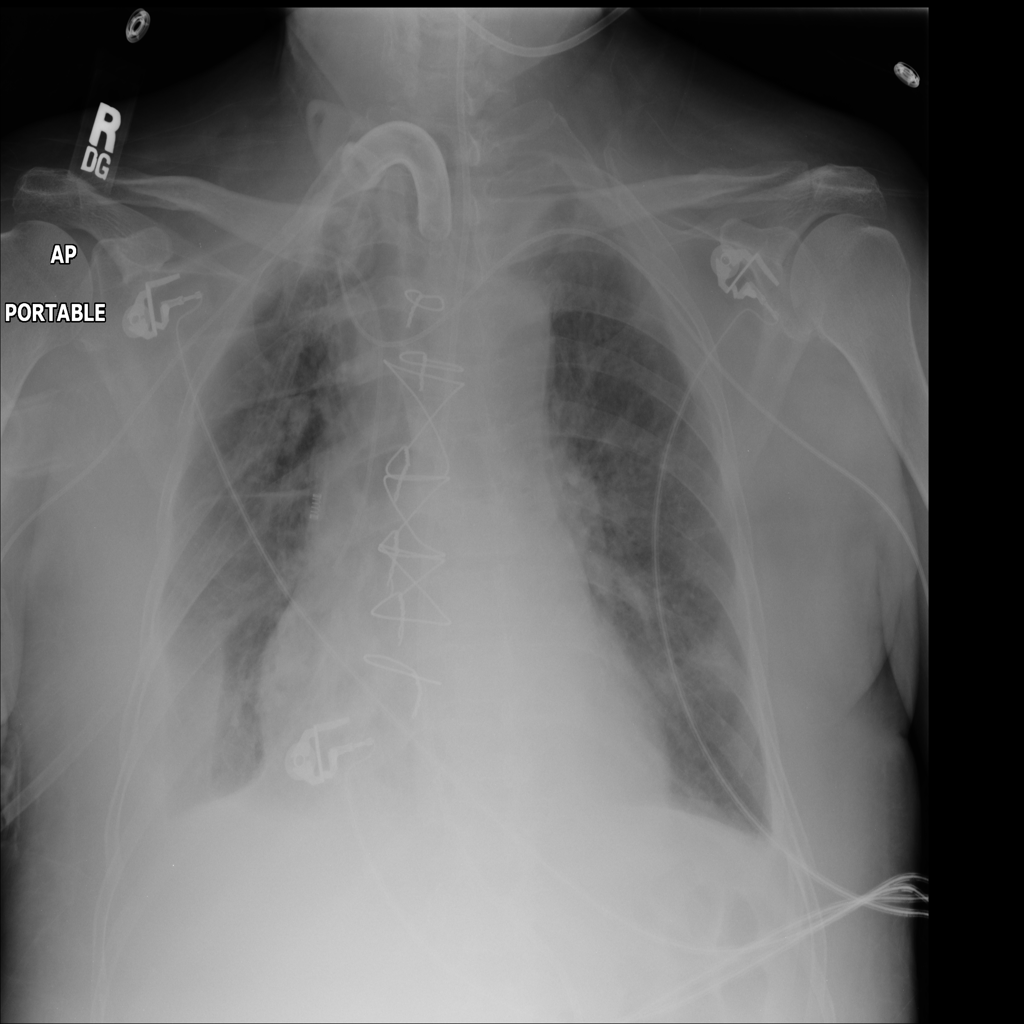

In [403]:
batch_holder = np.zeros((200, IMG_SIZE, IMG_SIZE, 3))
test_images_path = test_df.sample(10)['Image Path']
for i, image_path in enumerator(test_images_path):
    img = image.load_img(image_path, target_size = (IMG_SIZE, IMG_SIZE))
    batch_holder[i, :] = img
    
result = model.predict_classes(batch_holder)

fig = plt.figure(figsize=(20, 20))
 
for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title(get_label_name(result[i][0]))
  plt.imshow(img/256.)
  
plt.show()